In [1]:
import math
import os
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import keras
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw
from keras import datasets, layers, models
from keras.layers import Dense, Dropout
import matplotlib.patches as patches
from sklearn.preprocessing import LabelBinarizer
from keras.utils import to_categorical, load_img, img_to_array, array_to_img
from sklearn.model_selection import train_test_split
import cv2
from keras.applications import VGG16
from keras.layers import Input, Flatten
from keras.models import Model
from keras.optimizers import Adam

2023-01-25 11:46:32.567056: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
root_path = os.path.join(os.getcwd(), 'auth_data')

In [3]:
#Re-Order
label_csv = "labels.csv"
label_csv_path = os.path.join(root_path, label_csv)
df = pd.read_csv(label_csv_path)
ds = df.sample(frac=1)
print(ds.head(3))
ds.to_csv(os.path.join(root_path, label_csv_path), index=False)

                      file  label
1239  Sign-up-fde21731.png      3
2694  Sign-up-5e8e3cf8.png      3
695   Sign-in-c7db0c58.png      2


In [4]:
im_width = 64
im_height = 48
classes = ['Login', 'SignIn', 'SignUp']
data = []
labels = []
imagePaths = []

In [5]:
def create_sets():
    ds_path = os.path.join(root_path, "labels.csv")
    image_root = os.path.join(root_path, 'img_dir')
    image_records = pd.read_csv(ds_path)

    for index, row in image_records.iterrows():
        
        (filename, label) = row

        image_path = os.path.join(image_root, filename)
        train_img = load_img(image_path, target_size=(im_height, im_width))
        image = img_to_array(train_img)

        data.append(image)
        labels.append(label)
        imagePaths.append(image_path)
    

create_sets()

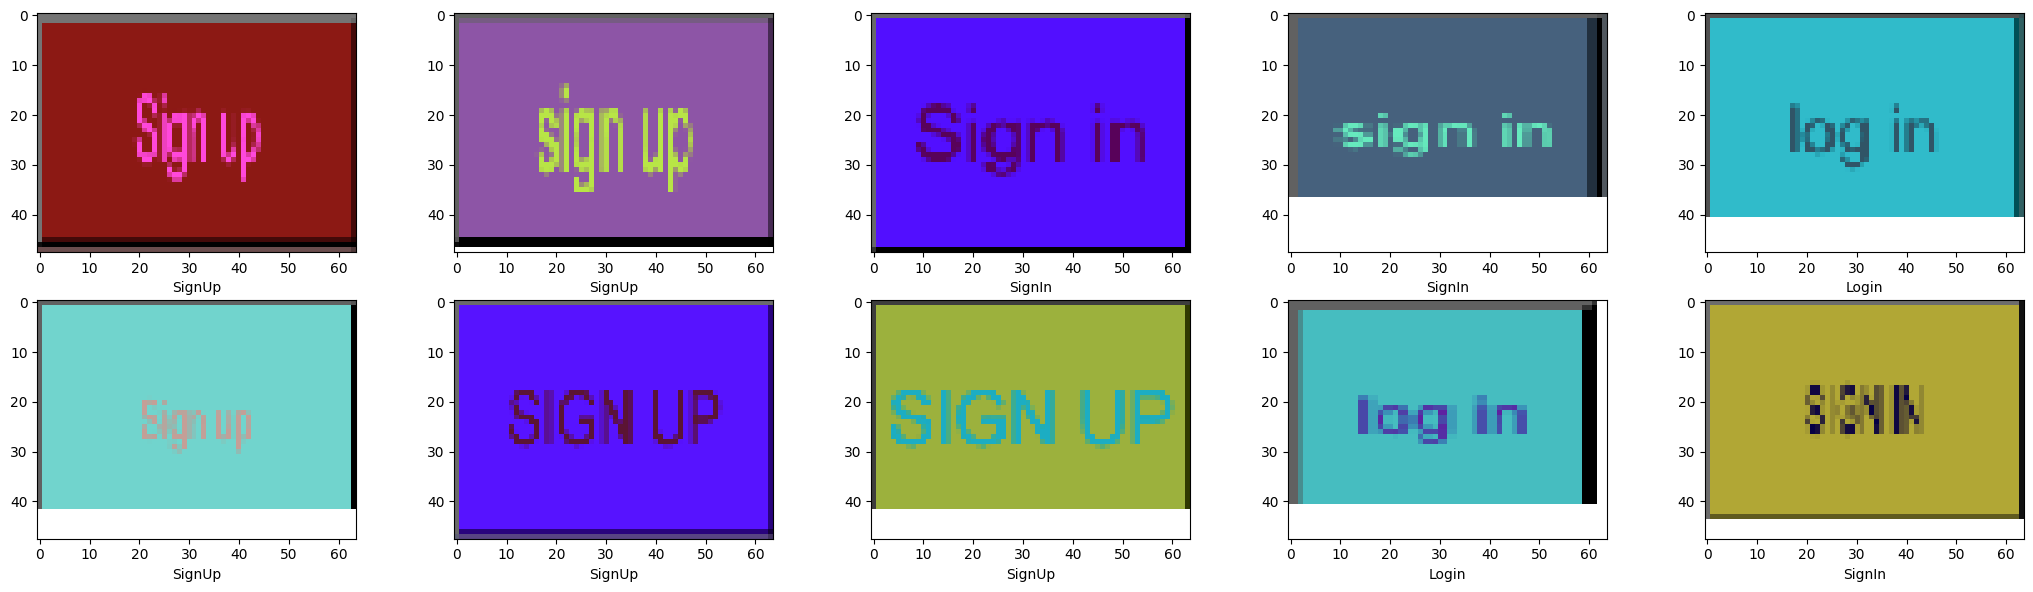

In [6]:
#Show
def show():
    plt.figure(figsize=(26,18))
    for i in range(10):
        plt.subplot(5,5,i+1)
        plt.xlabel(classes[labels[i]-1])
        plt.imshow(array_to_img(data[i]))
        
show()

In [7]:
# convert from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0

print(data.shape)

#convert to numpy array
labels = np.array(labels)
imagePaths = np.array(imagePaths)

(3597, 48, 64, 3)


In [8]:
# one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [9]:
if len(lb.classes_) == 2:
    print("two classes")
    labels = to_categorical(labels)
print(labels)

[[0 0 1]
 [0 0 1]
 [0 1 0]
 ...
 [1 0 0]
 [0 1 0]
 [0 1 0]]


In [10]:
split = train_test_split(data,
                         labels,
                         imagePaths,
                         test_size=0.20,
                         random_state=42)

In [11]:
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainPaths, testPaths) = split[4:]
print(trainImages.shape)
print(trainLabels.shape)

(2877, 48, 64, 3)
(2877, 3)


In [12]:
model=Sequential()
model.add(layers.Conv2D(filters=32,kernel_size=(4,4),input_shape=(48,64,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # Drop 25% of the units from the layer.
model.add(layers.Conv2D(filters=32,kernel_size=(4,4),input_shape=(48,64,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(layers.Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(len(classes),activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

2023-01-25 11:46:43.901757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
#training
batch_size = 64
epoch = 10

history = model.fit(trainImages, trainLabels, epochs=epoch, batch_size=batch_size, validation_data=(testImages,testLabels))

Epoch 1/10
45/45 [==============================] - 7s 138ms/step - loss: 1.1238 - accuracy: 0.3705 - val_loss: 1.0891 - val_accuracy: 0.3903
Epoch 2/10
45/45 [==============================] - 6s 134ms/step - loss: 1.0774 - accuracy: 0.3865 - val_loss: 1.0600 - val_accuracy: 0.3875
Epoch 3/10
45/45 [==============================] - 6s 136ms/step - loss: 1.0050 - accuracy: 0.4585 - val_loss: 0.8901 - val_accuracy: 0.6403
Epoch 4/10
45/45 [==============================] - 6s 136ms/step - loss: 0.7694 - accuracy: 0.6660 - val_loss: 0.6415 - val_accuracy: 0.7611
Epoch 5/10
45/45 [==============================] - 6s 128ms/step - loss: 0.5210 - accuracy: 0.7918 - val_loss: 0.4167 - val_accuracy: 0.8472
Epoch 6/10
45/45 [==============================] - 6s 129ms/step - loss: 0.3993 - accuracy: 0.8540 - val_loss: 0.3739 - val_accuracy: 0.8611
Epoch 7/10
45/45 [==============================] - 7s 147ms/step - loss: 0.3465 - accuracy: 0.8742 - val_loss: 0.2968 - val_accuracy: 0.9153
Epoch 

<AxesSubplot:>

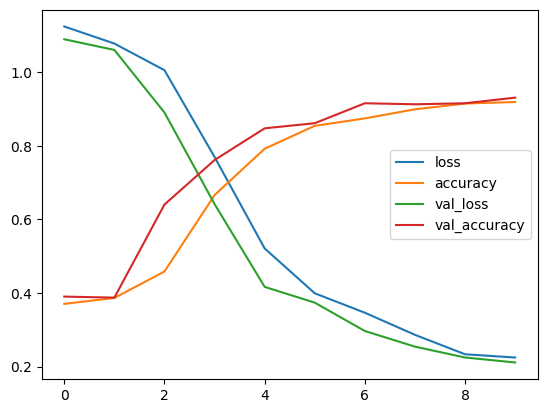

In [14]:
# Plotting train vs validation
import pandas as pd
pd.DataFrame(history.history).plot()

In [15]:
model_name = os.path.join(root_path, 'auth_model.h5')
model.save(model_name)

In [16]:
# Prediction
from keras.preprocessing import image
from keras.models import load_model

model_loaded = load_model(model_name)

filename = 'background.png'
test_image = os.path.join(os.getcwd(), 'login', 'test_images', filename)

img = image.image_utils.load_img(test_image, target_size=(im_height, im_width))
img = image.image_utils.img_to_array(img)
img = img.reshape((1,) + img.shape)
img = img/255.

y_prob = model_loaded.predict(img)
y_classes = y_prob.argmax(axis=-1)
pred = classes[y_classes[0]] 
print(pred)

for idx, result in enumerate(y_prob[0]):
    if result * 100 > 80:
        print(f"Prediction higher than 80 {result * 100}% class {classes[idx]}")
    else:
        print(f"{result}")

1/1 [==============================] - 0s 128ms/step
Login
Prediction higher than 80 99.99997615814209% class Login
2.6738428005046444e-07
6.92190416096139e-10
